## Семинар 7: "Методы оптимизации"

ФИО: Алибаева Камила Винеровна

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [100]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self):
        #super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
                
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                
class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-8
            
    def step(self):
        #super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g += param.grad ** 2
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                
class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        self.p = 0
        
        self.gamma = gamma
    
    def step(self):
        #super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                tetta = torch.sqrt(self.p + self.eps) / torch.sqrt(g + self.eps) * param.grad
                param -= tetta
                self.p = self.gamma * self.p + (1 - self.gamma) * tetta ** 2
                
class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, betta1=0.9, betta2=0.999):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.m = [torch.zeros_like(param) for param in self.parameters]
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.eps = 10e-8
        self.betta1 = betta1
        self.betta2 = betta2
        self.betta1_t = betta1
        self.betta2_t = betta2
    
    def step(self):
        #super().step(F)
        
        with torch.no_grad():
            for param, (m, v) in zip(self.parameters, zip(self.m, self.v)):
                m.copy_(self.betta1 * m + (1 - self.betta1) * param.grad)
                v.copy_(self.betta2 * v + (1 - self.betta2) * param.grad ** 2)
                param -= self.learning_rate / torch.sqrt(v / (1 - self.betta2_t)
                                        + self.eps) * m / (1 - self.betta1_t)
                self.betta1_t *= self.betta1
                self.betta2_t *= self.betta2

In [101]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    #return (x**2).sum(-1)
    
    x, y = x[0], x[1]
    
    return torch.sin(x) * x**2 * y + torch.cos(y**2) * y**2

optimizers = [SGD, NAG, Momentum, RMSProp, Adagrad, Adam, Adadelta]
colors = ["red", "blue", "yellow", "pink", "orange", "green", "purple"]

optim_path = []

def opt(F):
    for optim in optimizers:
        print(optim.__name__)

        x = torch.tensor(x_0, requires_grad=True)
        optim = optim([x], learning_rate=0.01)

        points = []

        for i in range(20):
            p_z = F(x.reshape(2, 1)).item()
            #print(p_z)

            p_x, p_y = x.detach().numpy().flatten()        
            print(p_z, p_x, p_y)
            points.append((p_x, p_y, p_z))

            optim.step(lambda: F(x.reshape(2, 1)))
            optim.zero_grad()

        optim_path.append(points)
        
opt(F)

SGD
4.197285699848428 2.5 1.5
3.978263171493663 2.530221803149728 1.5339606404651196
3.7047278873107397 2.5660815948352935 1.5700450061241644
3.3647973003206135 2.6089565699512414 1.6071544687069266
2.938038444572745 2.660611329783325 1.6438522586132913
2.385468837461182 2.7233051449054773 1.6786452039836819
1.6351733405148754 2.7999285998873558 1.710443918834479
0.563892706906941 2.894177418444646 1.7390385676912736
-1.0278431353645838 3.010756196115029 1.7653807731291138
-3.451281497552369 3.15554550232734 1.791604522832424
-7.1693560082387044 3.3355041682486055 1.820898298453461
-12.78934769281189 3.5577004852479903 1.8572908063213969
-20.840624599396822 3.8261393576171048 1.9050133219571714
-31.04577002295977 4.134368346391237 1.966477641575276
-41.29732275767162 4.454206116018318 2.038160280437247
-48.391469059990754 4.7330012693464525 2.1079549506388995
-51.41810197564188 4.922765325234459 2.1625213610024994
-52.22650992036478 5.021545043108722 2.1989362415919143
-52.393964803810

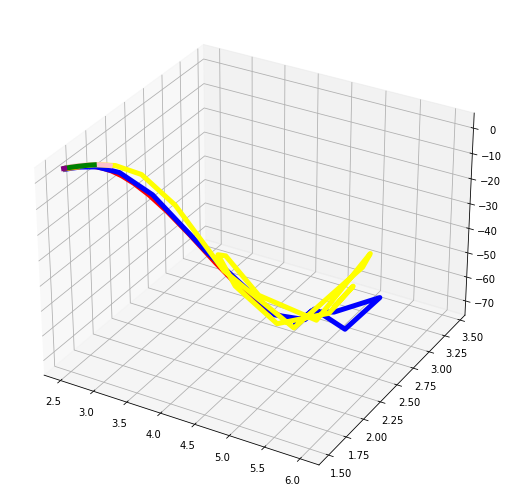

In [57]:
def plot():
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a basic wireframe.
    #ax.plot_wireframe(space, space, Z)

    for color, path in zip(colors, optim_path):
        points = np.array(path)
        #print(points)
        points += np.random.rand(3) * 0.04
        ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

    """
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)
    """

    #ax.view_init(30, 45)
    plt.show()
    
plot()

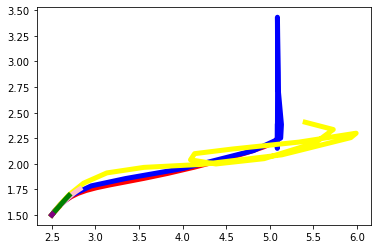

In [26]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [59]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

optim_path = []
opt(f)

SGD
8.5 2.5 1.5
8.163400000000001 2.45 1.47
7.840129360000001 2.4010000000000002 1.4405999999999999
7.529660237344 2.35298 1.4117879999999998
7.231485691945178 2.3059204 1.3835522399999998
6.9451188585441495 2.2598019920000003 1.3558811951999998
6.670092151745801 2.2146059521600003 1.3287635712959998
6.405956502536667 2.1703138331168 1.3021882998700798
6.152280625036214 2.126907556454464 1.2761445338726782
5.90865031228478 2.0843694053253747 1.2506216431952246
5.674667759918303 2.0426820172188673 1.22560921033132
5.449950916625538 2.00182837687449 1.2010970261246936
5.234132860327167 1.9617918093370001 1.1770750856021996
5.026861199058211 1.9225559731502602 1.1535335838901557
4.827797495575505 1.8841048536872549 1.1304629122123526
4.636616714750716 1.8464227566135099 1.1078536539681056
4.4530066928465875 1.8094943014812397 1.0856965808887435
4.2766676278098625 1.7733044154516149 1.0639826492709687
4.107311589748592 1.7378383271425826 1.0427029962855494
3.9446620507945482 1.703081560599

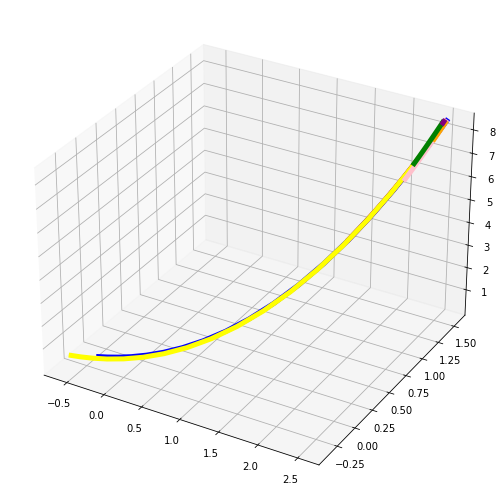

In [60]:
plot()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [61]:
f = lambda X: X[0] ** 2 * torch.sin(X[0]) + X[1] ** 2 * torch.sin(X[1])

optim_path = []
opt(f)

SGD
5.98481462050885 2.5 1.5
5.842870139911936 2.5201478687664856 1.4684835633643551
5.692044433883103 2.542439974380342 1.4370650072789342
5.5304603945936375 2.5671447619306282 1.4058267943983263
5.355546872625051 2.594571002644757 1.3748463813250709
5.163836040629929 2.6250746753423426 1.3441954640621392
4.950700679486109 2.6590669606537367 1.3139394092803076
4.7100121249203895 2.6970233896420726 1.2841368714853136
4.433695293281769 2.7394940590871233 1.2548395881401586
4.111154212031998 2.787114572891539 1.2260923382922906
3.7285430680261147 2.840616904263066 1.197933045494056
3.267870866113597 2.9008385540737938 1.1703930028208887
2.705966039822025 2.968726988329952 1.1434971964644518
2.0134159147530584 3.0453340612363906 1.117264704477012
1.15377652362174 3.1317915925302184 1.0917091484753765
0.08367859029094216 3.229254179695926 1.0668391781637045
-1.2450167155723402 3.3387889651401386 1.0426589711031067
-2.879191716824322 3.4611864259386924 1.0191687329768027
-4.852346234542219 

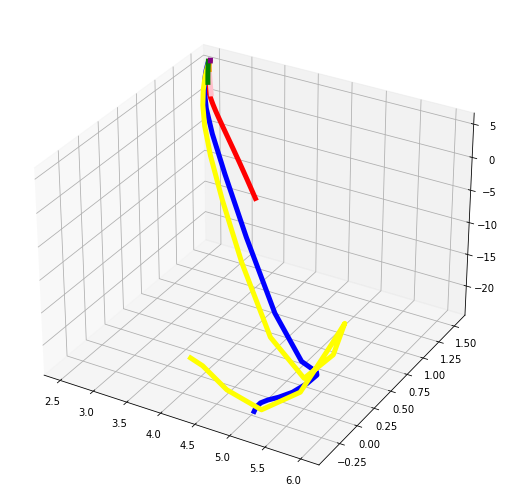

In [62]:
plot()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [63]:
f = lambda X: X[0] ** 2 * torch.sin(X[0] ** 2) + X[1] ** 2 * torch.sin(X[1] ** 2)

optim_path = []
opt(f)

SGD
1.5432945895755925 2.5 1.5
-3.0684377205788853 2.1893310176322216 1.5190595236271474
-3.1750703724773506 2.216039161454947 1.5436602193608446
-3.2951014937738803 2.216582114362237 1.575809802743496
-3.5077948163555823 2.216569210912101 1.61842708414426
-3.895414487498419 2.2165695281575934 1.6757595223660873
-4.611492034686642 2.2165695203639415 1.75372384884703
-5.883449218258125 2.2165695205554092 1.8590470568770512
-7.743324648369699 2.2165695205507054 1.9927454758803005
-9.274200444314488 2.216569520550821 2.12901517520771
-9.62262517403407 2.2165695205508182 2.205403243890847
-9.628939469994688 2.2165695205508182 2.216647236277693
-9.628939779235967 2.2165695205508182 2.216567601958605
-9.628939779424424 2.2165695205508182 2.216569567679359
-9.628939779424538 2.2165695205508182 2.2165695193930035
-9.628939779424538 2.2165695205508182 2.216569520579262
-9.628939779424538 2.2165695205508182 2.2165695205501192
-9.628939779424538 2.2165695205508182 2.216569520550835
-9.62893977942

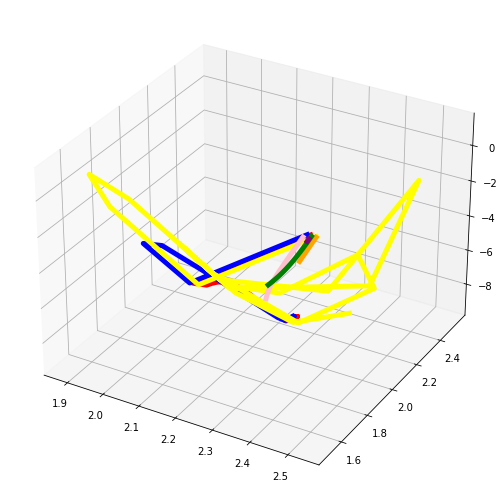

In [64]:
plot()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [68]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

/bin/bash: wget: command not found
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [69]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [77]:
from IPython.display import clear_output

preds = []
y_true = []
xs = []

def train(network, epochs, learning_rate, optimizer):
    loss = nn.NLLLoss()
    optimizer = optimizer(network.parameters(), learning_rate=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                optimizer.zero_grad()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                if (epoch == 4):
                    for i in range(y.shape[0]):
                        if y[i] != np.argmax(prediction[i].detach().numpy()):
                            xs.append(X[i])
                            preds.append(np.argmax(prediction[i].detach().numpy()))
                            y_true.append(y[i])
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.876/0.814	Accuracy: 0.819/0.833


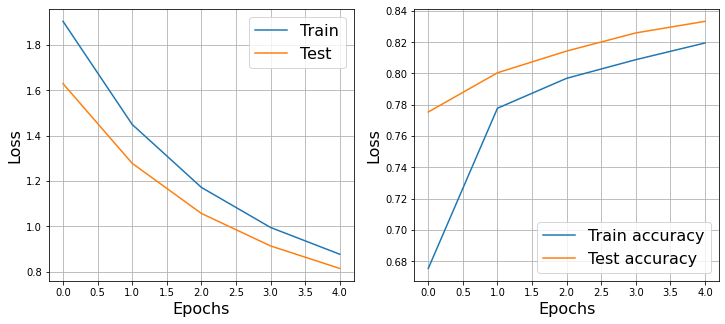

In [83]:
channels = 1

class ConvClassifier1(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layer1 = nn.Sequential(nn.Conv2d(channels, 8, (3, 3), padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_layer2 = nn.Sequential(nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU(), nn.Flatten())
        self.linear_layer = nn.Sequential(nn.Linear(image_size * 2*image_size * 2, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        return x
    
network = ConvClassifier1(image_size=28)
train(network, 5, 1e-4, Adagrad)

Epoch 4... (Train/Test) NLL: 0.068/0.062	Accuracy: 0.980/0.980


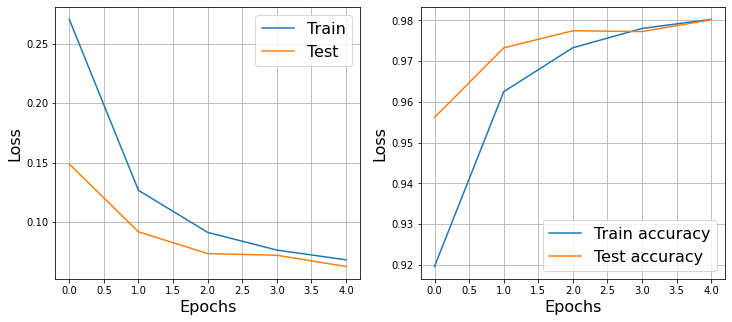

In [84]:
train(network, 5, 1e-4, Adadelta)

Epoch 4... (Train/Test) NLL: 0.042/0.049	Accuracy: 0.988/0.983


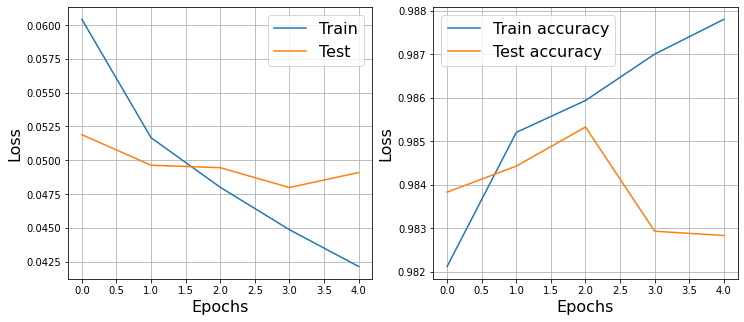

In [98]:
train(network, 5, 1e-4, Adam)

Epoch 4... (Train/Test) NLL: 0.036/0.045	Accuracy: 0.990/0.985


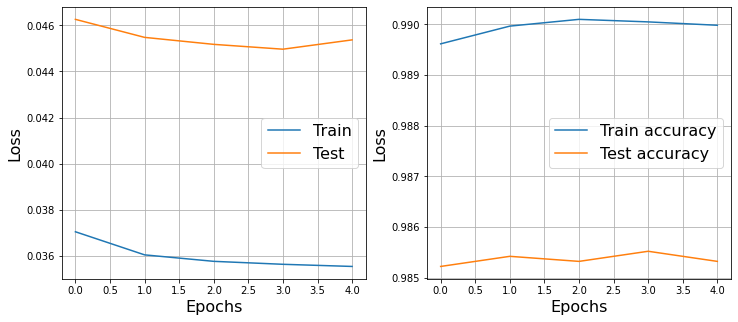

In [99]:
train(network, 5, 1e-4, SGD)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: